# Chapter 1. Neural encoding I: Firing rates and spike statistics

In [83]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import random
from spike_generator import *
#plt.style.use('seaborn-whitegrid');
plt.style.use('dark_background')
%matplotlib inline

## Task 1. Poisson spike train generators
Generate spikes for 10 s (or longer if you want better statistics) using
a Poisson spike generator with a constant rate of 100 Hz, and record
their times of occurrence. Compute the coefficient of variation of the
interspike intervals, and the Fano factor for spike counts obtained
over counting intervals ranging from 1 to 100 ms. Plot the interspike
interval histogram.

In [2]:
spikes = HomogeneousPoissonEfficient(100, 10)
print('Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)')
print(fano(spikes)[0])

Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)
0.9929657221143908


In [3]:
m = HomogeneousPoisson(100, 100)
m2 = HomogeneousPoissonEfficient(100, 100)

#plt.vlines(m, 0, 1)
#plt.vlines(m2, 0, 1)
#plt.title('Spike Train', loc='left')

### ISI (interspike intervals) distribution (density)

In [7]:
ISI_distribution( HomogeneousPoissonEfficient(100, 100) )

<IPython.core.display.Javascript object>

As can be seen, distribution is exponentially decaying, which makes sense, because the longer it has been since
last spike the more likely it will be fired soon. 
Due to the absense of refractoriness, distribution has the peak at 0. But in real neurons there is refractoriness
after firing the spike and, thus, no spike can be fired immediately after this event.

### Spike counts distribution
Firing rate 100 Hz

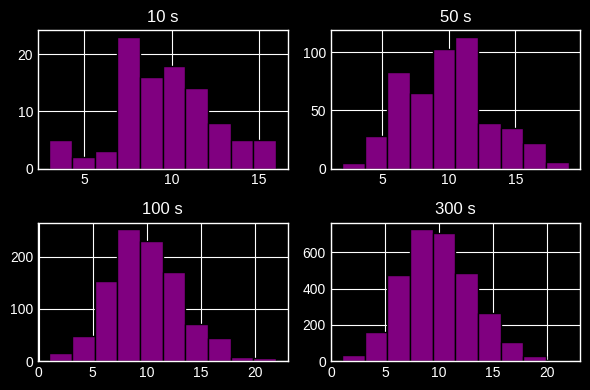

In [10]:
spikes = HomogeneousPoissonEfficient(100, 600)
distribution_spike_counts(spikes)

fig, axs = plt.subplots(2, 2)
fig.dpi=100
axs[0, 0].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 10)), color='purple', ec='black')
axs[0, 0].set_title('10 s')
axs[0, 1].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 50)), color='purple', ec='black' )
axs[0, 1].set_title('50 s')
axs[1, 0].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 100)), color='purple', ec='black' )
axs[1, 0].set_title('100 s')
axs[1, 1].hist( distribution_spike_counts(HomogeneousPoissonEfficient(100, 300)), color='purple', ec='black' )
axs[1, 1].set_title('300 s')
plt.tight_layout()

As can be seen, for larger simulation times, distribution of counter spikes approaches normal distribution

### Compute the coefficient of variation ($C_V$) of ISI

In [6]:
isi = np.diff(m)
cv = coefficient_variation(isi)
print('Coefficient of variation: %s' % cv)

Coefficient of variation: 0.9484771134645107


### Compute the coefficient of variation ($C_V$) and fano factor for spike counts

In [7]:
cv = coefficient_variation(m)
print('Coefficient of variation: %s' % cv)

fano_factor = fano(m)
print('Fano factor: %s' % fano_factor[0])

Coefficient of variation: 0.572159066076243
Fano factor: 0.8993889327826061


## Task 2. Refractory period

Add a refractory period to the Poisson spike generator by allowing
the firing rate to depend on time. Initially, set the firing rate to a
constant value, $r(t) = r_0 $. After every spike, set $r(t)$ to 0, and then
allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$
that controls the refractory recovery rate. In other words, have $r(t)$
obey the equation

$$
\tau_{ref} \frac{dr}{dt} = r_0 - r
$$

except immediately after a spike, when it is set to 0.
Plot the coefficient of variation as a function of $\tau_{ref}$ over
the range $1 \ ms\ \le \tau_{ref} \le 20 \ ms$, and plot interspike interval histograms for a few values of $\tau_{ref}$ in this range.
Compute the Fano factor for spike counts obtaines over counting
intervals ranging from 1 to 100 ms for the case $\tau_{ref}=10 \ ms$

If we solve the above equaition, we will get:
$$
r(t) = r_0 - (r_0 - r_{init})\cdot \exp{\left(-\frac{t}{\tau_{ref}}\right)}
$$

(0.0, 100.0)

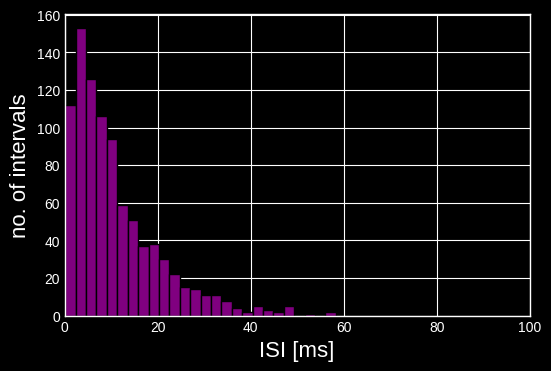

In [11]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=1)
ISI_distribution(spikes_refrac)
plt.xlim(0, 100)

(0.0, 100.0)

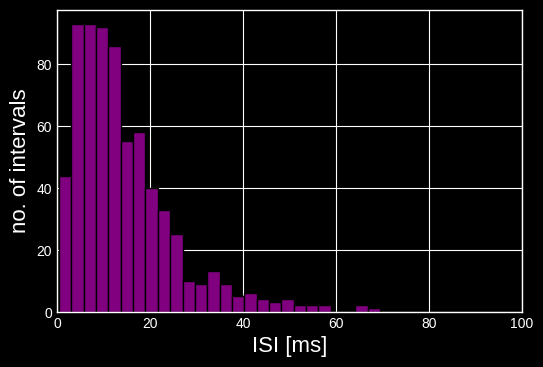

In [12]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=5)
ISI_distribution(spikes_refrac)
plt.xlim(0, 100)

(0.0, 100.0)

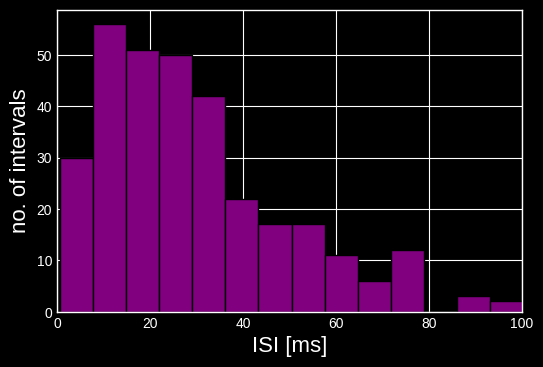

In [13]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=20)
ISI_distribution(spikes_refrac)
plt.xlim(0, 100)

(0.0, 100.0)

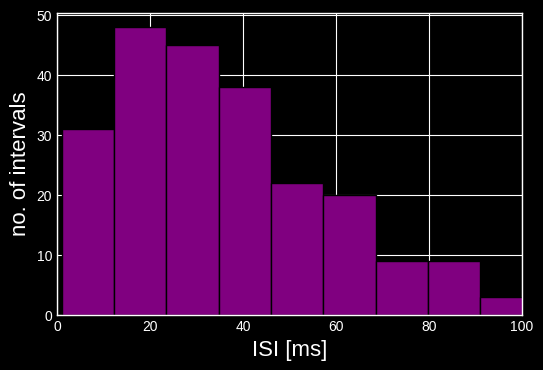

In [14]:
spikes_refrac = HomogeneousPoissonRefractory(100, 10, tau=30)
ISI_distribution(spikes_refrac);
plt.xlim(0, 100)

Plottting coefficient of variation ($C_V$) of ISI as a fucntion of $\tau_{ref}$

In [16]:
coeffs = []
for i in range(21, 1, -1):
    spikes = HomogeneousPoissonRefractory(100, 500, tau=i)
    isi = np.diff(spikes)
    coeffs.append(coefficient_variation(isi))

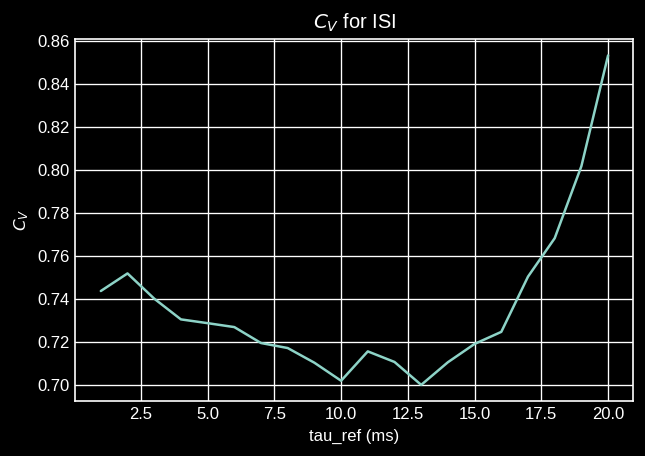

In [18]:
plt.figure(dpi=120)
plt.plot([i for i in range(1, 21) ] , coeffs)
plt.xlabel('tau_ref (ms)')
plt.ylabel('$C_V$')
plt.title('$C_V$ for ISI')
plt.show()

Plotting $C_V$ as a function of average ISI (different firing rates) with $\tau_{ref}$ = 10 ms

In [195]:
coeffs = []
for i in range(1, 100):
    spikes = HomogeneousPoissonRefractory(i, 1000, tau=2)
    isi = np.diff(spikes)
    coeffs.append(coefficient_variation(isi))

average_ISI = [ (1/i)*1000 for i in range(1, 100) ]

The **greater $\tau_{ref}$**, the longer we see less variance for different values of average ISI. Because for a longer period of time we have smaller probability of firing an action potential => variance decreases

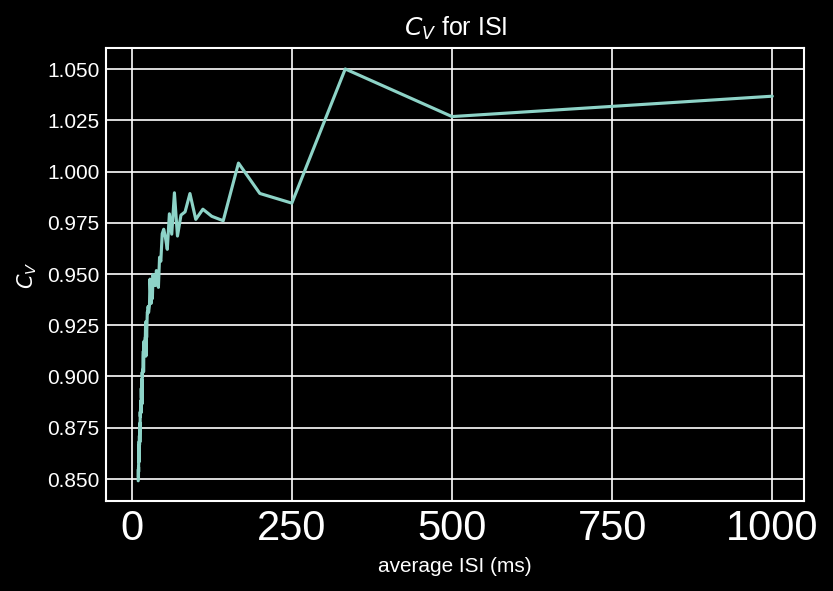

In [196]:
plt.figure(dpi=150)
plt.plot(average_ISI , coeffs)
plt.xlabel('average ISI (ms)')
plt.ylabel('$C_V$')
plt.title('$C_V$ for ISI')
plt.show()

Plottting coefficient of variation ($C_V$) of spike_counts as a fucntion of $\tau_{ref}$

In [13]:
coeffs = []
for i in range(1, 21):
    spikes = HomogeneousPoissonRefractory(100, 500, tau=i)
    coeffs.append(coefficient_variation(spike_count(spikes, step_interval=100)))

<IPython.core.display.Javascript object>


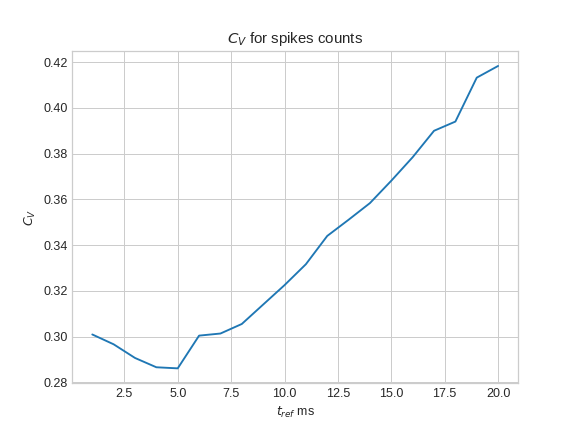

In [14]:
plt.figure()
plt.plot([i for i in range(1, 21)], coeffs)
plt.xlabel('$t_{ref}$ ms')
plt.ylabel('$C_V$')
plt.title('$C_V$ for spikes counts')
plt.show()

Computing Fano factors for spikes counts with step intervals [1, 100] ms

In [15]:
print( fano(HomogeneousPoissonRefractory(100, 10, tau=10)) )

[0.9514020556830656, 0.9315418444425315, 0.8829390500313541, 0.8671904650657617, 0.8350147753773767, 0.819266190411784, 0.7952021604340384, 0.7794001876258766, 0.7883165354011117, 0.768592179091509, 0.7241495118977048, 0.6796001426305499, 0.6673271287234327, 0.6679570942404618, 0.6693153733600561, 0.7394985272024719, 0.6947354476142001, 0.6990493847222016, 0.700131307739364, 0.676814748326755, 0.6689740377702876, 0.6688900421959969, 0.6566404682668932, 0.6452759763441812, 0.620282340862423, 0.6057014853729432, 0.5785019675996391, 0.5851575197980426, 0.6192066184566856, 0.6384254079110773, 0.6093031830694018, 0.6761223110784553, 0.5960246948719513, 0.6020828084320148, 0.586730517942017, 0.5952240261179146, 0.6197530864197531, 0.5924204728598476, 0.5542373971193416, 0.5920410677618071, 0.5811004140438281, 0.6452259916312204, 0.5813291501793411, 0.6121172567574916, 0.6009342676009344, 0.5792987047467335, 0.6314794998602153, 0.6346549540993985, 0.5106511740498669, 0.5567864476386036, 0.565

Plotting spike times

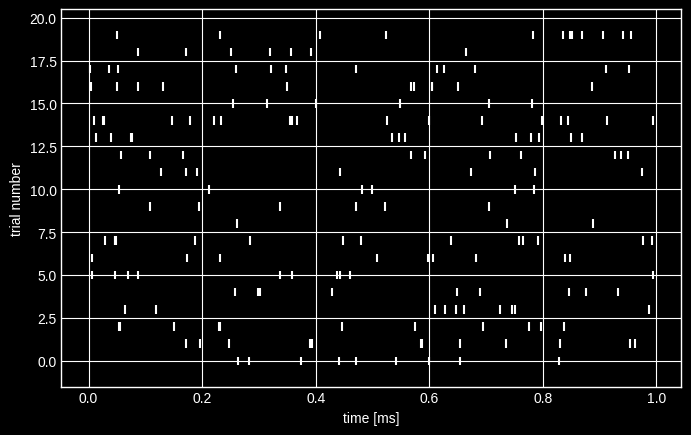

In [21]:
PlotTrials()

## Task 3. Autocorrelation
Compute autocorrelation histograms of spike trains generated by a Poisson generator with a
constant firing rate 100 Hz, a constant firing rate of 100 Hz together with a refractory period $\tau_{ref} = 10 \ ms$, and a variable firing rate:
$$
r(t) = 100\left(1 + \cos{\left(\frac{2\pi \cdot t}{25 \ ms}\right)}\right) \ Hz
$$
Plot the histograms over a range from 0 to 100 ms.


In [22]:
def rate_f(t):
    return 100*(1 + np.cos(2*np.pi*t*1000/25))


200.0


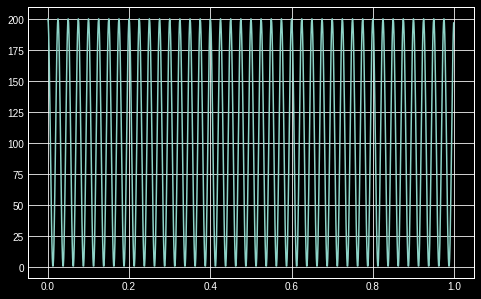

In [23]:
time = np.arange(0, 1, 0.001)
print(np.max( rate_f(time) ))
plt.figure(figsize=(8,5))
plt.plot(time, rate_f(time))

In [25]:
spikes1 = HomogeneousPoissonEfficient(200, 10)
locs1, freqs1 = autocorrelation(spikes1, time_lag=100, dt=1e-3)

spikes2 = HomogeneousPoissonRefractory(200, 10, tau=20)
locs2, freqs2 = autocorrelation(spikes2, time_lag=100, dt=1e-3)

spikes3 = NonhomogeneousPoisson(rate_func=rate_f, duration=10)
locs3, freqs3 = autocorrelation(spikes3, time_lag=100, dt=1e-3)

Building autocorrelation histograms for different parameters of simulation

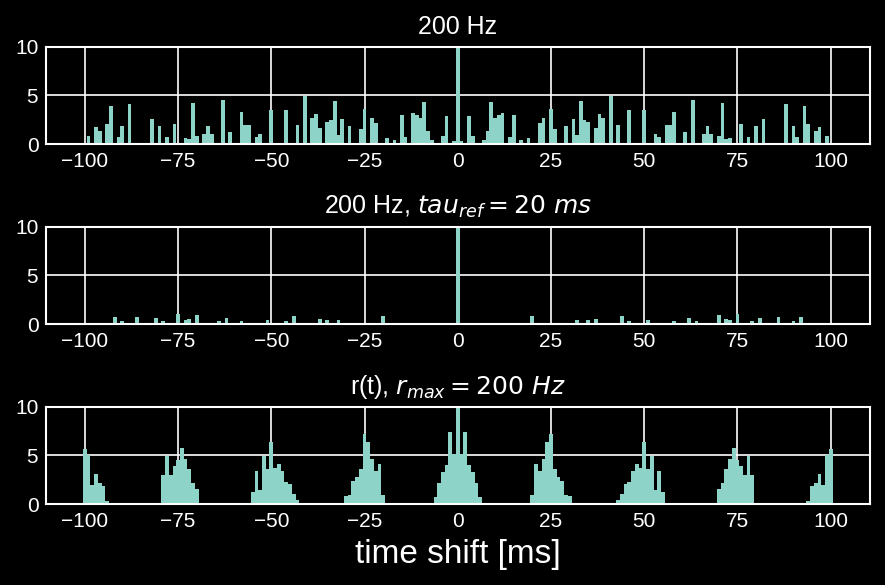

In [26]:
fig, axs = plt.subplots(3, 1)
fig.dpi=150

axs[0].bar(locs1, freqs1, width=1, bottom=0)
axs[0].set_ylim(0,10)
axs[0].set_title('200 Hz')

axs[1].bar(locs2, freqs2, width=1, bottom=0)
axs[1].set_ylim(0,10)
axs[1].set_title('200 Hz, $tau_{ref}=20 \ ms$')

axs[2].bar(locs3, freqs3, width=1, bottom=0)
axs[2].set_ylim(0,10)
axs[2].set_xlabel('time shift [ms]', fontsize=16)
axs[2].set_title('r(t), $r_{max} = 200 \ Hz$')

plt.tight_layout()
plt.show()

(I don't know how to check whether my autocorrelation works correctly. But the output seems reasonable)

## Task 4. Approximating firing rate with ODE
Generate a Poisson spike train with time-dependent firing rate $r(t) = 100(1 + \cos{(2\pi t/300  \ ms)}) \ Hz$. Approximate the firing rate from this spike train using a variable $r_{approx}$ that satisfies:
$$
\tau_{approx} \frac{dr_{approx}}{dt} = -r_{approx}
$$

except that $r_{approx} \rightarrow r_{approx} + 1/\tau_{approx}$ every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate.
Experiment with a few different values of $\tau_{approx}$ in the range of 1 to 100 ms. Determine the best value of $\tau_{approx}$ by computing the average squarred error of the estimate,
$$
\int{r(t)\cdot dt} - (r_{approx}(t))^2
$$
for different values of $\tau_{approx}$, and finding the value of $\tau_{approx}$ that minimizes the error.

If we solve the above differential equation, we will get:

$$
    r_{approx}(t) = r_{0}\exp{\left(-\frac{t}{\tau_{approx}}\right)}
$$
After each spike we calculate $r_0 = r_{approx}(t_{spike}) + 1/\tau_{approx}$

In [4]:
def NonhomogeneousPoissonRapprox(r_approx, duration, tau=10, dt=1e-2):
    '''
    Nonhomogeneous Poisson spike generator,
    after each spike firing rate is increased by 1000/tau Hz,
    and decays exponentially  exp(-t*1000/tau)

    Return: array with spike times
    '''
    time = np.arange(0, 10, dt)
    r0 = 200
    spikes = [0]
    r_approx_vec = []
    for i in range(1, len(time)):
        r = r_approx(time[i] - spikes[-1] , r0, tau_approx=tau)
        r_approx_vec.append(r)
        print(r*dt)
        if  r*dt > np.random.rand():
            spikes.append(time[i])
            r0 = r + (1000/tau)
    return np.array(spikes), np.array(r_approx_vec)



Other way around

It is the only way I could make it work

In [5]:
def NonhomogeneousPoissonRapprox(r_approx, duration, tau=10, r_max=200):
    '''
    Nonhomogeneous Poisson spike generator,
    after each spike firing rate is increased by 1000/tau Hz,
    and decays exponentially  exp(-t/tau)

    Return: array with spike times
    '''
    r_approx_vec = []
    spikes = HomogeneousPoissonEfficient(r_max, 10)
    spikes_thinned = [ spikes[0] ]
    r0 = 1000/tau
    for i in range(1, len(spikes) ):
        # here should be spikes[i] - spikes_thinned[-1] but it does not work at all
        r = r_approx(spikes[i] - spikes[i-1], r0, tau_approx=tau)
        r_approx_vec.append(r)
        if r / r_max > np.random.rand():
            spikes_thinned.append(spikes[i])
            
    return np.array(spikes_thinned), np.array(r_approx_vec)


In [6]:
def r(t):
    return 100 * (1 + np.cos(2*np.pi*t*1000/300)) # Hz

def r_approx(t, r0, tau_approx=10):
    return r0*np.exp(-t * 1000/tau_approx)

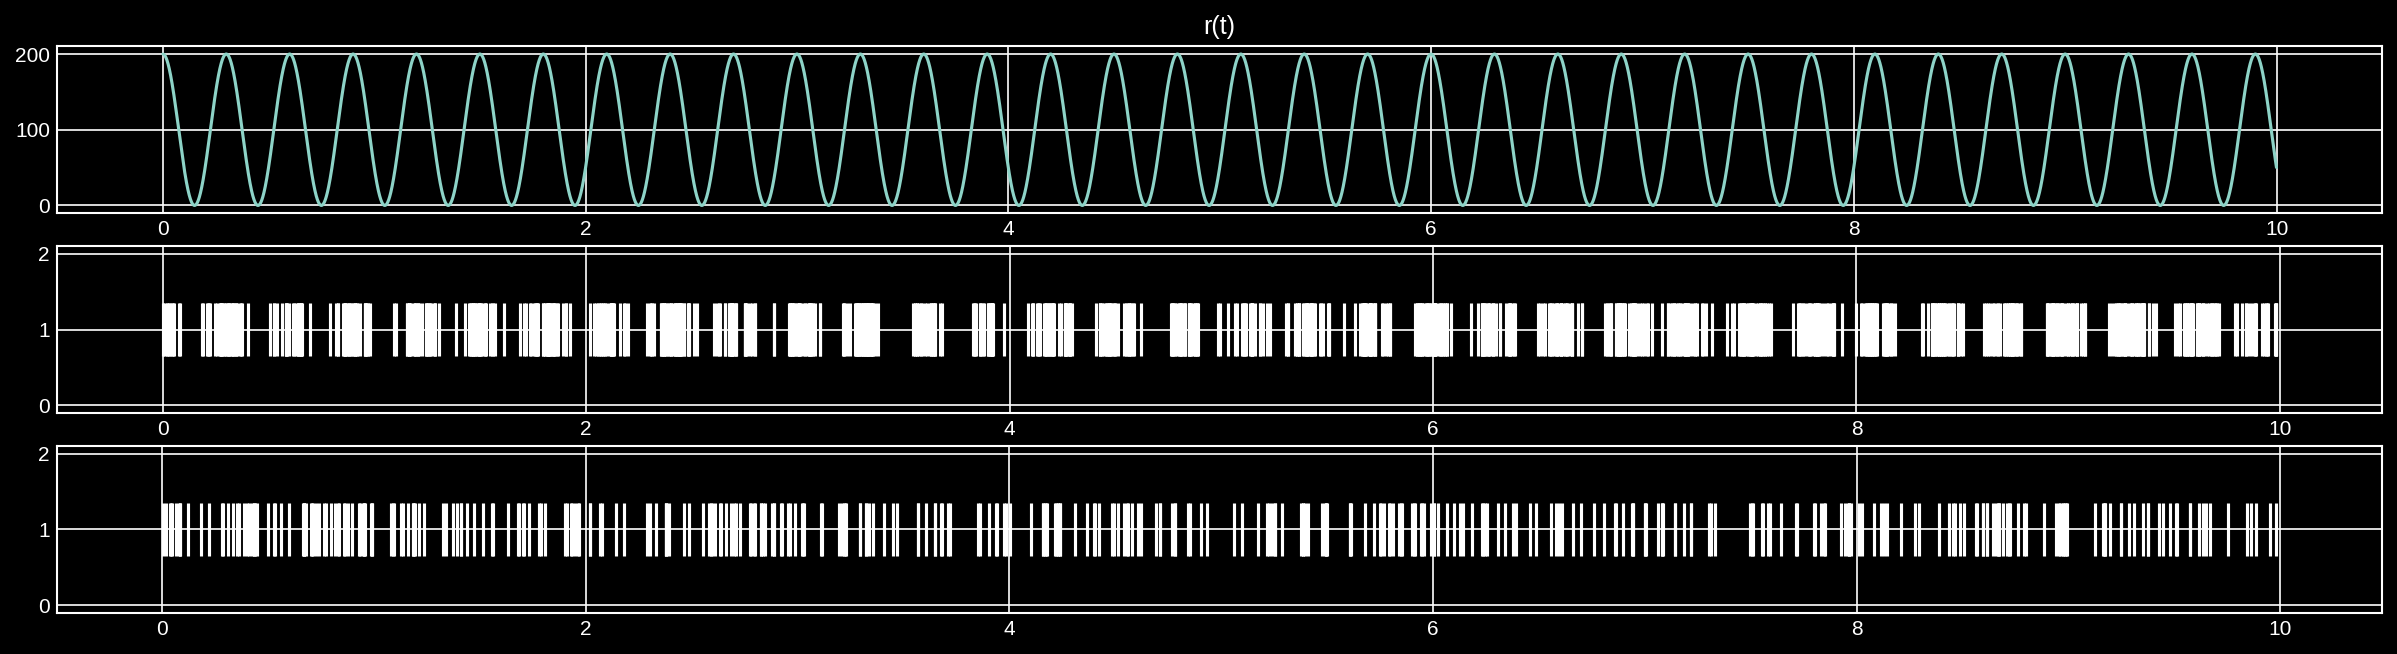

In [10]:
spikes = NonhomogeneousPoisson(r, 10)
spikes2, r_approx_vec = NonhomogeneousPoissonRapprox(r_approx=r_approx,  duration=10, tau=20)

fig, axs = plt.subplots(3, 1, figsize=(20, 5));
time = np.arange(0, 10, 1e-4)
fig.dpi=150
axs[0].plot(time, r(time));
axs[0].set_title('r(t)')

axs[1].eventplot(spikes, linelength=0.7);

axs[2].eventplot(spikes2, linelength=0.7);

## Task 5. Poisson paradox
For a constant rate Poisson process, every specific sequence of N spikes occuring over a given time interval is equally likely. This seems paradoxical because we certainly do not expect to see all N spikes appearing within the first 1% of the time interval. Resolve this paradox.

First, let's write the probability of N spikes to occur in an interval T:

$$
P_T[N] = \left(\frac{T}{N!}\right)^N \cdot \exp{(-rT)}
$$

As can be seen from this formula for Poisson distribution, the smaller $rT$ term and higher expected number of spikes $N$, the lesser probability that given $N$ spikes occur over given time interval. Therefore, it is more likely for $N$ spikes to occur over larger time interval. And we can consider $N$ occuring in the first 1% of the time interval the same as large expected value of $N$ spikes over short time interval + 0 spikes over 99% of the interval, which are both very unlikely events.

Now let's look at it from combinatorial perspective, suppose we have spike times 


$$
\{t_1, t_2,  \ ... \ , t_N\}
$$


let $N = 7$ spikes and let $M = 1000$ time bins, then 1% of bins is $F=1000 \cdot 0.01=10$. Now, what is the number of ways to put 7 spikes into 10
bins? It is the same as choosing 7 bins from 10, where order does not matter (1, 5, 10 and 5, 1, 10 does not change that spikes occur at those times)


$$
\frac{10!}{7!(10-7)!} = \frac{10\cdot 9 \cdot 8}{3 \cdot 2} = 120 
$$


So, we have 120 ways of putting 7 spikes into 10 bins and the number of ways to put 0 spikes into 990 bins is 1. ($120 \cdot 1 = 1$)
And the general number of ways to put 7 spikes into 1000 bins is:


$$
\frac{1000!}{7!(1000-7!)} = 194280608456793000
$$


The fraction $\frac{120}{194280608456793000}$ is very small. Even if we account for "shifts of this 1%" we will not get much higher probability:


$$
120 \cdot (1000/10) = 12 0000; \ \frac{12 000}{194280608456793000} = 6.176 \cdot 10^{-14}
$$


Therefore, although each combination is equally likely over a given time interval, the total number of such "spikes in the 1% of time" combinations is limited compared to the
total number of combinations.
Actually, such combinatorial reasoning coupled with limit $\Delta t \rightarrow 0$ is used in the derivation of the above formula for Poisson distribution.

## Task 6. White-noise stimulus
Build an approximate white-noise stimulus by choosing random values at discrete times separated by time interval $\Delta t$. Plot its **autocorrelation** function and **power spectrum**. Discuss how well this stimulus matches an ideal white-noise stimulus given the value of $\Delta t$ you used.

Let's assume that whatever stimulus we had. We normalized it to be in range $[0, 1]$:

In [183]:
Δt = 1e-2
time = np.arange(0, 10, Δt)
stimulus = np.random.uniform(0, 10, *np.shape(time)) 

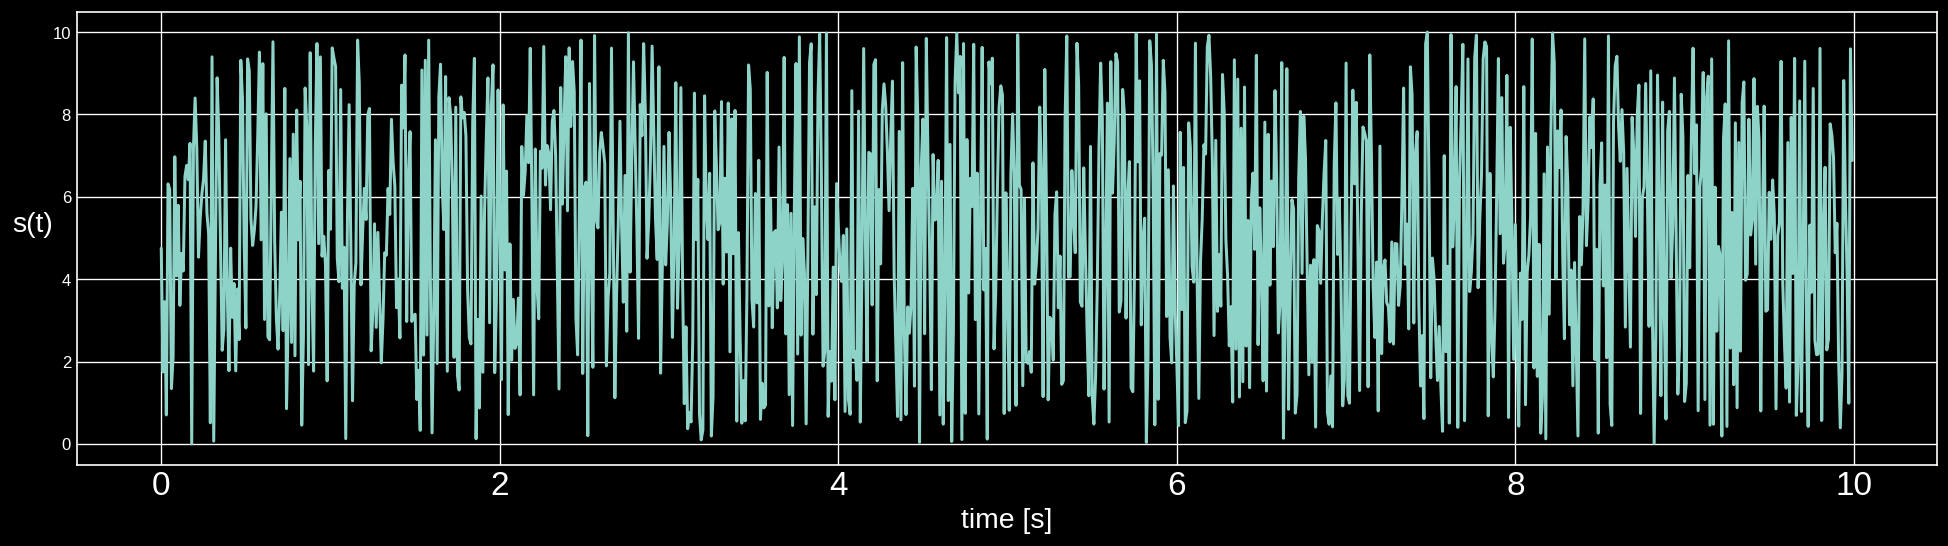

In [184]:
plt.figure(figsize=(20, 5), dpi=120);
plt.plot(time, stimulus, lw=1.8);
plt.xlabel('time [s]', fontsize=17);
plt.ylabel('s(t)', rotation=0, fontsize=17, labelpad=12);

### Power spectrum
First, let's plot just spectral density

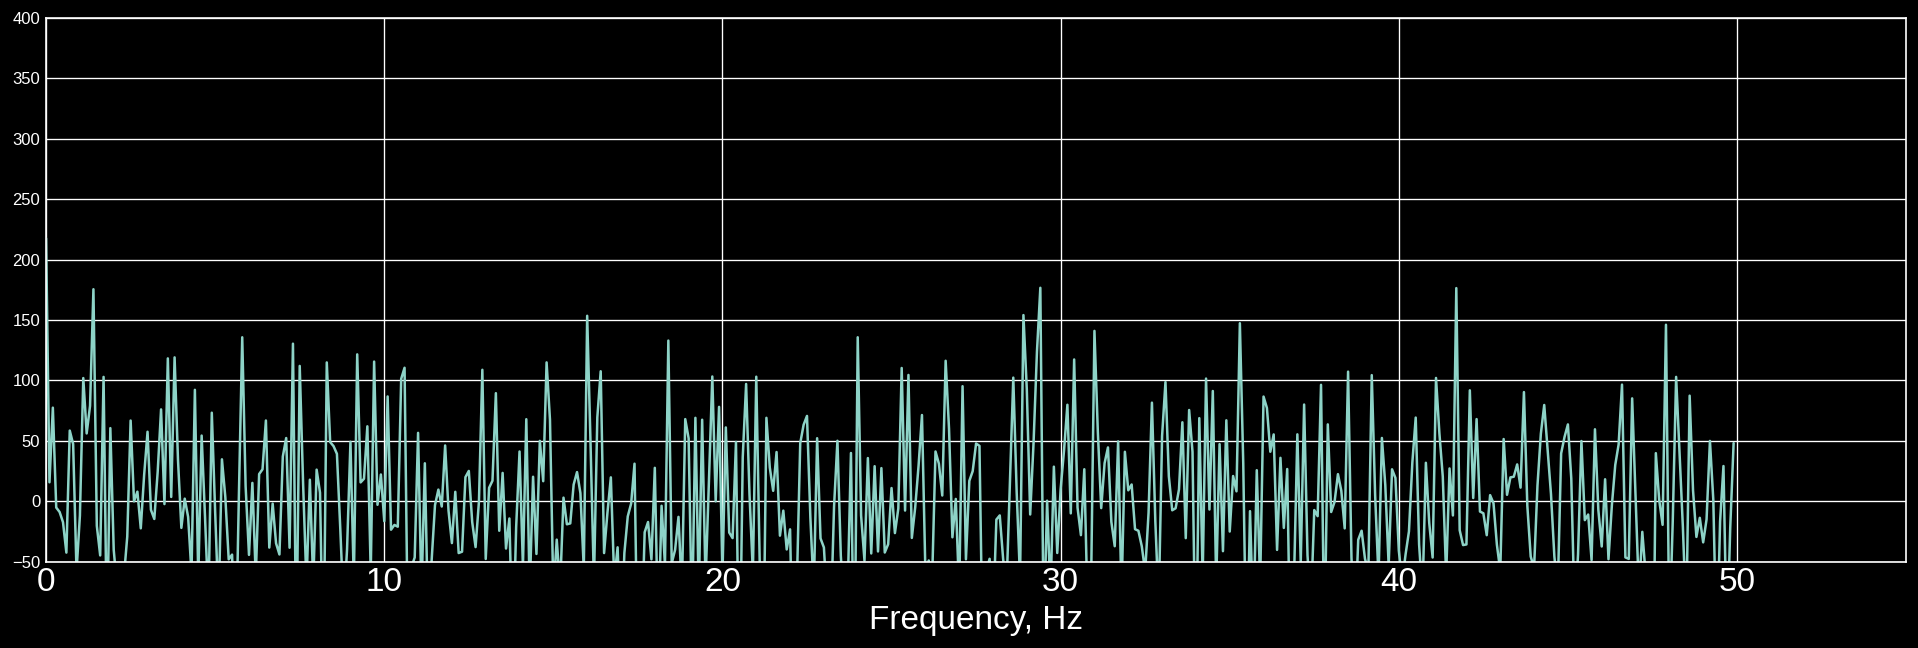

In [185]:
spectrum = np.fft.fft(stimulus)
freqs = np.fft.fftfreq(time.size, Δt)
plt.figure(figsize=(20, 6), dpi=120);
plt.plot(sorted(freqs), spectrum.real);
plt.xlim(0, 55);
plt.ylim(-50, 400);
plt.xlabel('Frequency, Hz', fontsize=20);
rc('xtick', labelsize=20);

And now the actual **power spectrum**

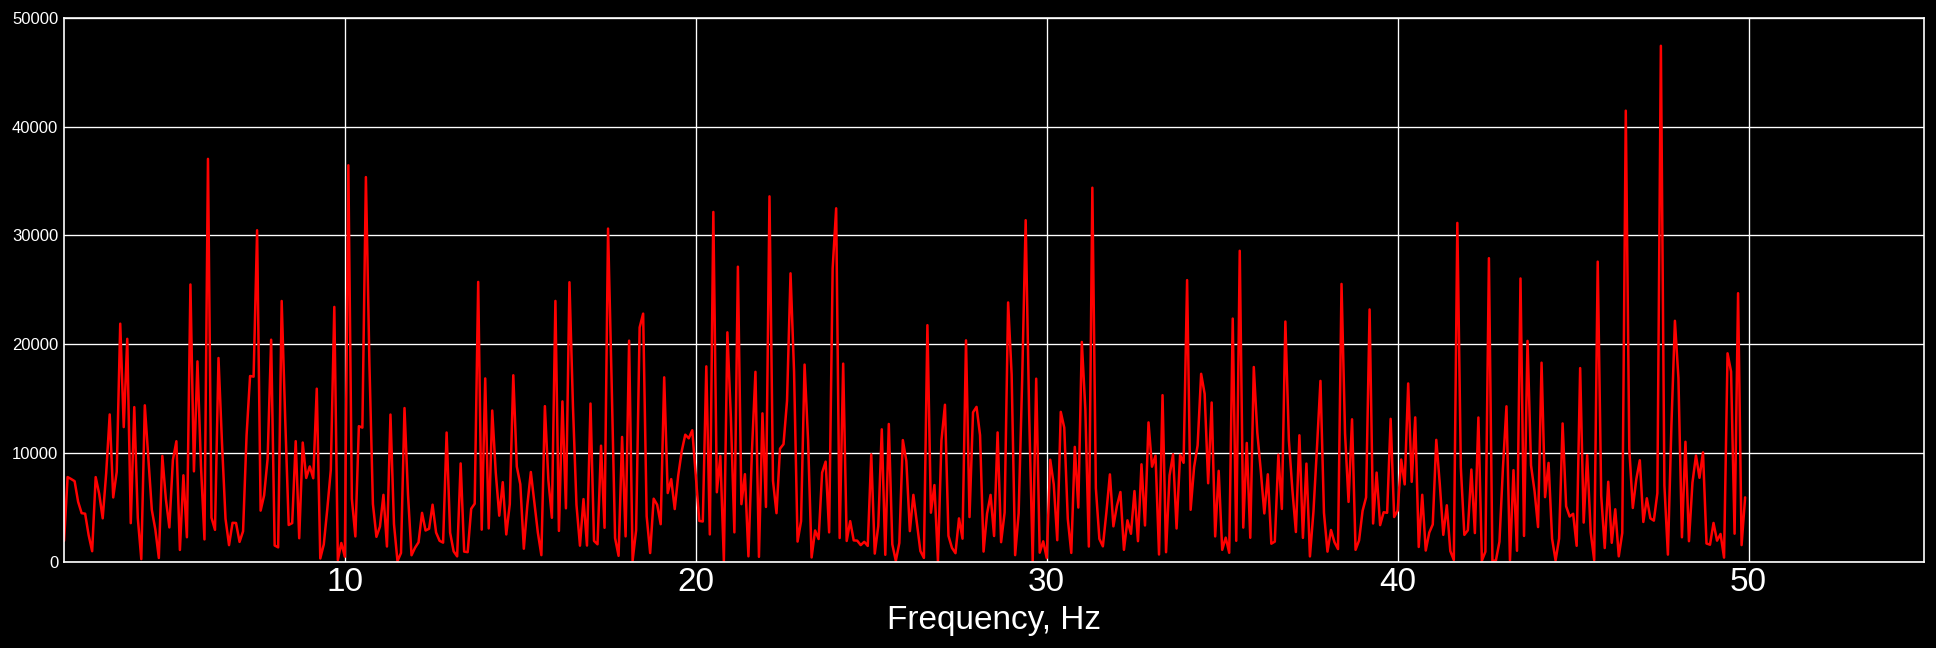

In [192]:
power_spectrum = np.abs(spectrum)**2
plt.figure(figsize=(20, 6), dpi=120);
plt.plot(sorted(freqs), power_spectrum, lw=1.5, color='red');
plt.xlim(2, 55);
plt.ylim(0, 5e4);
plt.xlabel('Frequency, Hz', fontsize=20);
rc('xtick', labelsize=20);

### Autocorrelation
Finally, **autocorrelation** of white-noise stimulus. But, for better approximatin, let's generate white noise for a longer period of time

(0.0, 3.0)

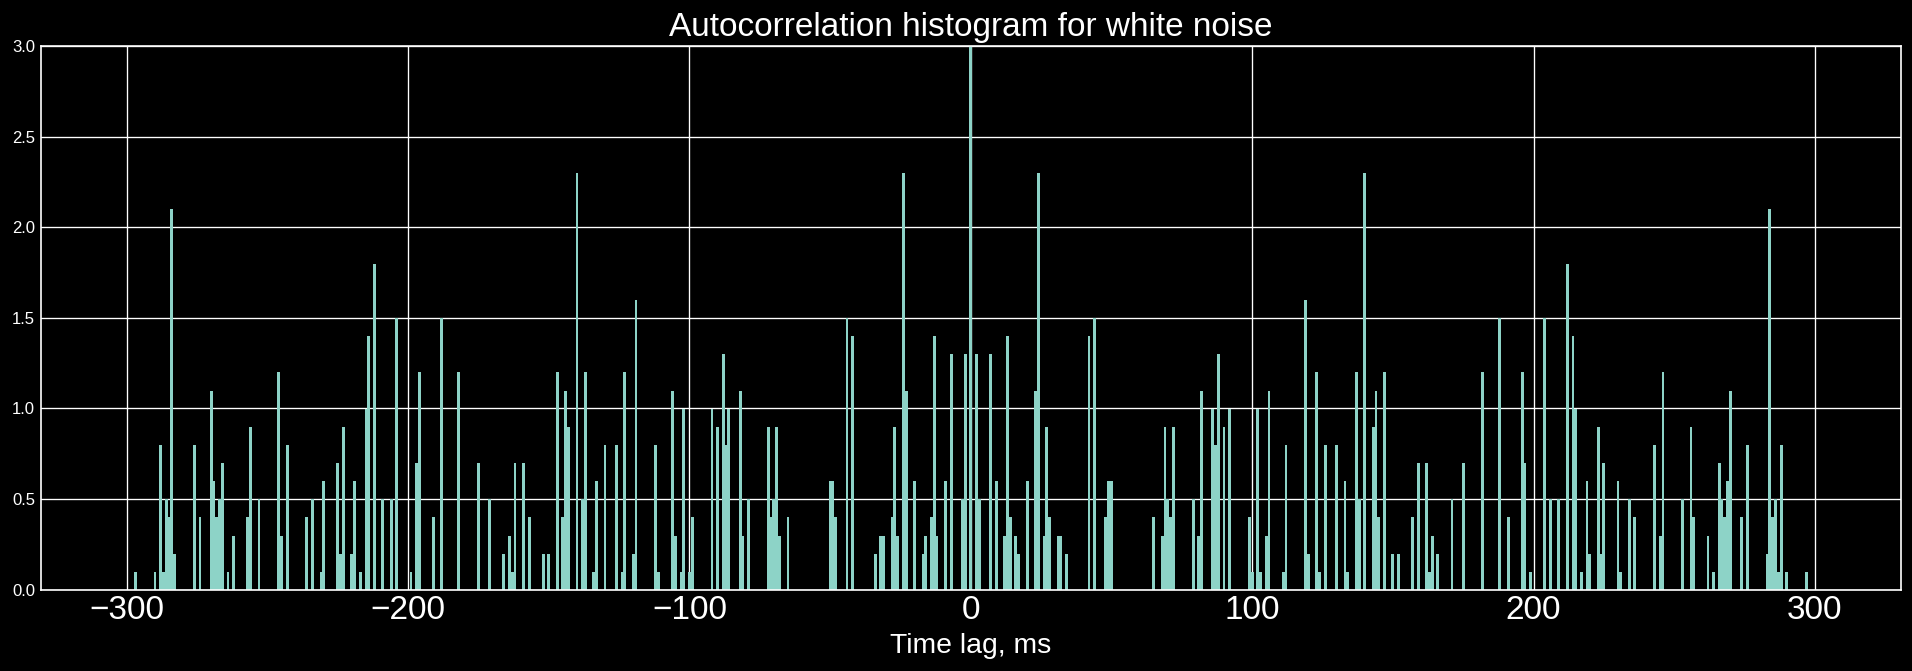

In [197]:
Δt = 1e-2
time_longer = np.arange(0, 10, Δt)
stimulus_longer = np.random.uniform(0, 10, *np.shape(time_longer))
locs, freqs = autocorrelation(stimulus, time_lag=300, dt=1e-3)
plt.figure(dpi=120, figsize=(20,6))
plt.bar(locs, freqs, width=1)
plt.xlabel('Time lag, ms', fontsize=17)
plt.title('Autocorrelation histogram for white noise', fontsize=20)
plt.ylim(0, 3)